<a href="https://colab.research.google.com/github/MystEric/Taller_3_Deep_Learning/blob/master/image2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from keras.datasets import cifar10
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization, Conv2DTranspose, ReLU, Concatenate, Dense, Activation, Reshape
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import load_model, Model, Sequential
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image 
from sklearn.metrics import label_ranking_average_precision_score

# **Carga de data**

In [16]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3)) 

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# **Visualización ruido**

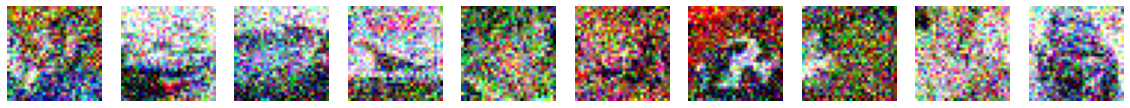

In [17]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
plt.show()

# **Modelo denoising autoencoder**

In [18]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)
   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)
   final_deconv = Conv2DTranspose(filters=3,
                       kernel_size=3,
                       padding='same')(deconv_block4)
   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   return Model(dae_inputs, dae_outputs, name='dae')

autoencoder = denoising_autoencoder()
autoencoder.summary()

Model: "dae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dae_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 32)   896         dae_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 16, 16, 32)   128         conv2d_10[0][0]                  
__________________________________________________________________________________________________
re_lu_18 (ReLU)                 (None, 16, 16, 32)   0           batch_normalization_18[0][0]     
________________________________________________________________________________________________

**Optimizador**

In [19]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/20
391/391 [==============================] - 33s 84ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 2/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 3/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 4/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 5/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 7/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 8/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 9/20
391/391 [==============================] - 32s 83ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/20
391/391 [==============================] - 32s 83ms/step - loss: 0.005

# **Visualizacion Denoising**

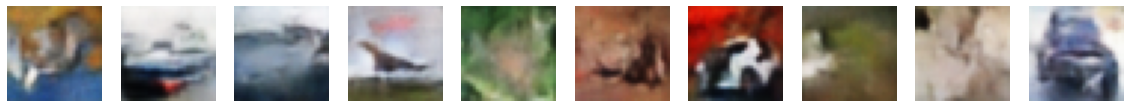

In [20]:
denoised_images=autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 3))
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(denoised_images[i])
    plt.axis('off')
plt.show()

**Encoder**

In [21]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=15).output)
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dae_input (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
re_lu_19 (ReLU)              (None, 8, 8, 64)         

# **Funciones para testeo y score**

In [22]:
def compute_average_precision_score(test_codes, test_labels, learned_codes, y_train, n_samples):
    out_labels = []
    out_distances = []

    for i in range(len(test_codes)):
        distances = []
        for code in learned_codes:
            distance = np.linalg.norm(code - test_codes[i])
            distances.append(distance)
        distances = np.array(distances)
        labels = np.copy(y_train)
        bin_labels=[]
        for label in labels:
          if label==test_labels[i]:
            bin_labels.append(1)
          else:
            bin_labels.append(0)
        
        if len(distances)< len(labels):
          n=len(distances)
        else:
          n=len(labels)

        distance_with_labels=[]
        for j in range(n):
          distance_with_labels.append([distances[j],bin_labels[j]])

        distance_with_labels.sort(key=lambda x: x[0])
        
        sorted_distances=[]
        sorted_labels=[]
  
        for k in range(len(distance_with_labels)):
          sorted_distances.append(28-distance_with_labels[k][0])
          sorted_labels.append(distance_with_labels[k][1])

        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])

    score = label_ranking_average_precision_score(out_labels, out_distances)

    scores.append(score)
    return score

def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []
    
    for code in learned_codes:
      distance = np.linalg.norm(code - test_code)
      distances.append(distance)
    nb_elements = learned_codes.shape[0]
    learned_code_index = np.arange(nb_elements)

    distances = np.array(distances)

    labels = np.copy(y_train)
    bin_labels=[]
    for label in labels:
      if label==test_label:
        bin_labels.append(1)
      else:
        bin_labels.append(0)
        
    if len(distances)< len(labels):
      n=len(distances)
    else:
      n=len(labels)

    distance_with_labels=[]
    for j in range(n):
       distance_with_labels.append([distances[j],bin_labels[j],learned_code_index[j]])

    distance_with_labels.sort(key=lambda x: x[0])
        
    sorted_distances=[]
    sorted_labels=[]
    sorted_indexes=[]

    for k in range(len(distance_with_labels)):
      sorted_distances.append(28-distance_with_labels[k][0])
      sorted_labels.append(distance_with_labels[k][1])
      sorted_indexes.append(distance_with_labels[k][2])

    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = test_element
    plt.imshow(original_image, interpolation='nearest')
    plt.show()
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    plt.figure(figsize=(20, 2))
    plt.imshow(retrieved_images, interpolation='nearest')
    plt.show()


Model score: 0.8303571428571428
Model score: 0.1363615560640732
Model score: 0.3265683629925969
Average precision ranking score for tested element is 0.7947278911564626


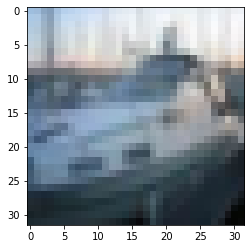

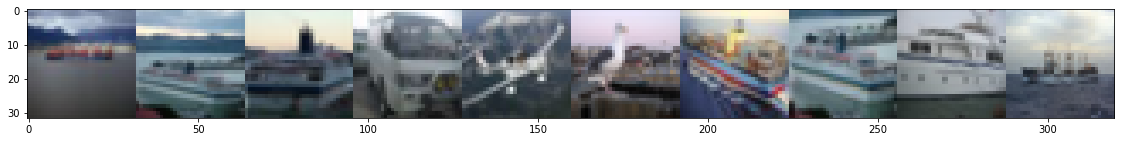

In [23]:

scores = []

n_test_samples = 1

n_train_samples = [10, 50,  100]
              # 200,300,500,700,1000,5000,10000,20000,30000]
                 
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3))
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, y_train, n_train_samples)
    print('Model score:', score)

for n_train_sample in n_train_samples:
    test_model(n_test_samples, n_train_sample)
 
retrieve_closest_images(x_test[2],y_test[2])

